In [699]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [700]:
df = pd.read_csv("data/Inventory_Waste_CompanyData.csv")
df.head()

,Job ID,Material Type,Area (sq/m),Thickness (mm),Material Cost (AED),Waste Percentage,Waste Cost (AED)
0,JOB_1,PI,68.64,20.0,2186.09,0.1750,382.57
1,JOB_2,GI,58.88,0.7,1017.49,0.0244,24.83
2,JOB_3,GI,35.81,0.7,630.32,0.0725,45.70
3,JOB_4,GI,14.00,1.1,380.97,0.1782,67.89
4,JOB_5,PI,15.80,25.0,634.38,0.1898,120.41


In [701]:
global_threshold = df['Waste Percentage'].mean()
print(f"Global threshold (mean): {global_threshold:.4f} ({global_threshold:.1%})")

df['High_Waste'] = (df['Waste Percentage'] > global_threshold).astype(int)

Global threshold (mean): 0.1040 (10.4%)


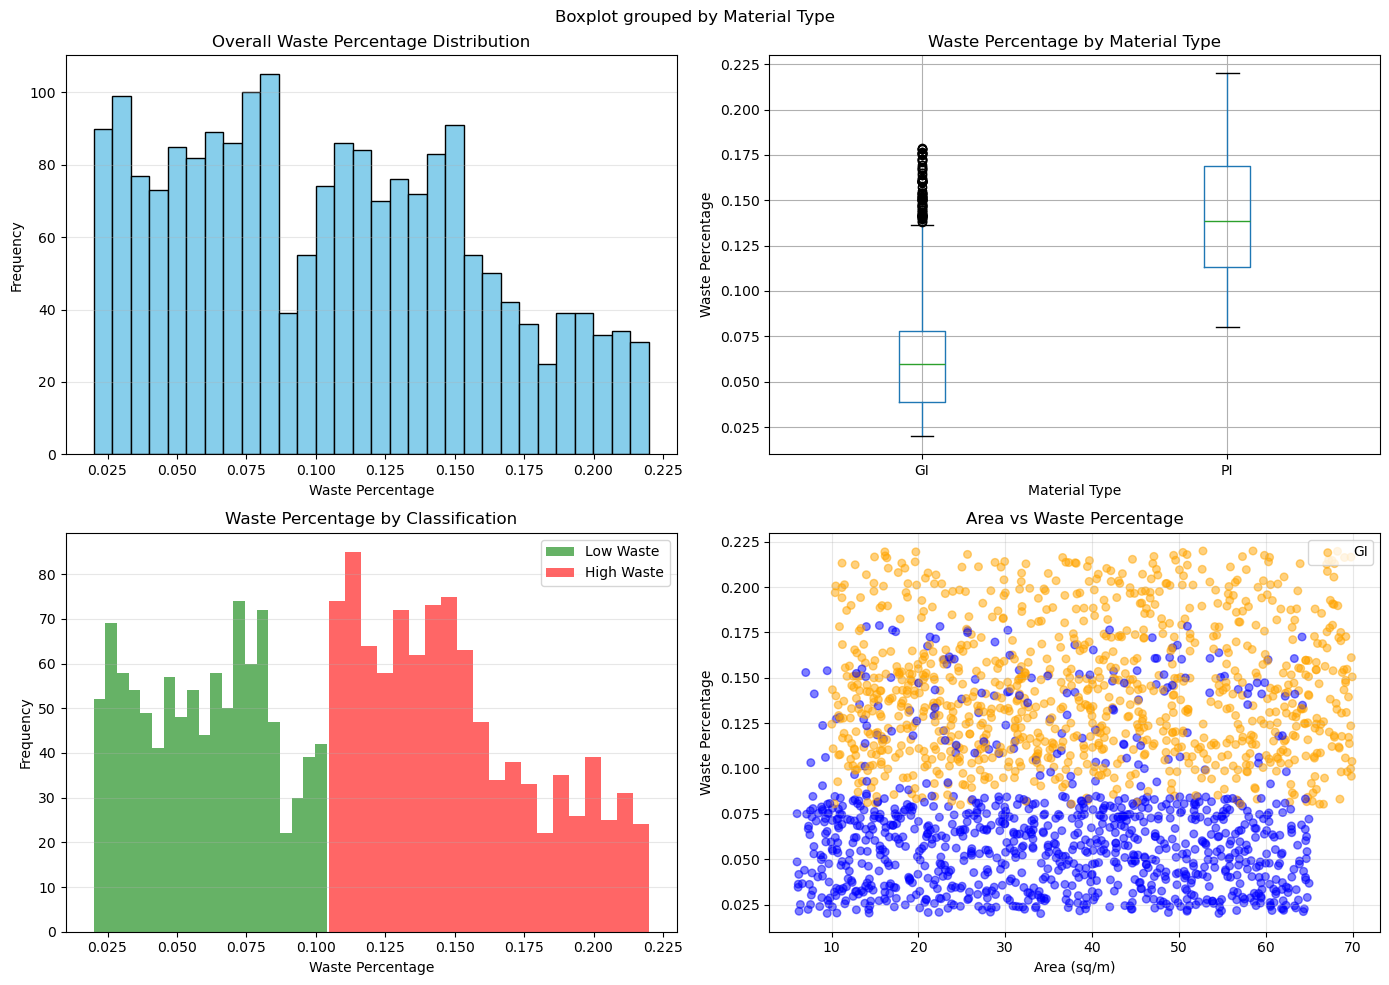

In [702]:
# Create a visualization of waste percentage distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall waste percentage distribution
axes[0, 0].hist(df['Waste Percentage'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Waste Percentage')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Overall Waste Percentage Distribution')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Waste percentage by material type (box plot)
df.boxplot(column='Waste Percentage', by='Material Type', ax=axes[0, 1])
axes[0, 1].set_xlabel('Material Type')
axes[0, 1].set_ylabel('Waste Percentage')
axes[0, 1].set_title('Waste Percentage by Material Type')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['GI', 'PI'])

# 3. Waste percentage by High_Waste category
axes[1, 0].hist(df[df['High_Waste']==0]['Waste Percentage'], alpha=0.6, label='Low Waste', bins=20, color='green')
axes[1, 0].hist(df[df['High_Waste']==1]['Waste Percentage'], alpha=0.6, label='High Waste', bins=20, color='red')
axes[1, 0].set_xlabel('Waste Percentage')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Waste Percentage by Classification')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Scatter plot: Area vs Waste Percentage colored by Material Type
colors = ['blue' if mt == 'GI' else 'orange' for mt in df['Material Type']]
axes[1, 1].scatter(df['Area (sq/m)'], df['Waste Percentage'], c=colors, alpha=0.5, s=30)
axes[1, 1].set_xlabel('Area (sq/m)')
axes[1, 1].set_ylabel('Waste Percentage')
axes[1, 1].set_title('Area vs Waste Percentage')
axes[1, 1].legend(['GI', 'PI'], loc='upper right')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

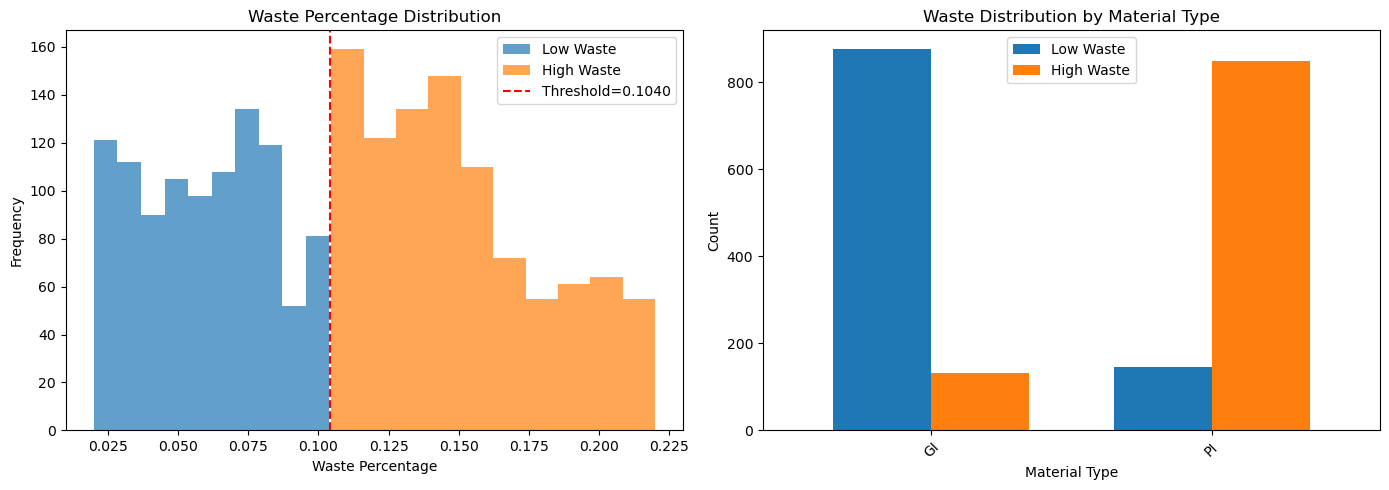

In [703]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df[df['High_Waste']==0]['Waste Percentage'], 
             alpha=0.7, label='Low Waste', bins=10)
axes[0].hist(df[df['High_Waste']==1]['Waste Percentage'], 
             alpha=0.7, label='High Waste', bins=10)
axes[0].axvline(x=global_threshold, color='red', linestyle='--', 
                label=f'Threshold={global_threshold:.4f}')
axes[0].set_xlabel('Waste Percentage')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Waste Percentage Distribution')
axes[0].legend()

waste_by_material = df.groupby(['Material Type', 'High_Waste']).size().unstack(fill_value=0)
waste_by_material.plot(kind='bar', ax=axes[1], width=0.7)
axes[1].set_xlabel('Material Type')
axes[1].set_ylabel('Count')
axes[1].set_title('Waste Distribution by Material Type')
axes[1].legend(['Low Waste', 'High Waste'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [704]:
features = ['Material Type', 'Area (sq/m)', 'Thickness (mm)']
target = 'High_Waste'

X = df[features].copy()
y = df[target]

label_encoder = LabelEncoder()
X['Material Type Encoded'] = label_encoder.fit_transform(X['Material Type'])
X = X.drop('Material Type', axis=1)

X.head()

,Area (sq/m),Thickness (mm),Material Type Encoded
0,68.64,20.0,1
1,58.88,0.7,0
2,35.81,0.7,0
3,14.00,1.1,0
4,15.80,25.0,1


In [705]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [706]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [707]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    knn, 
    param_grid, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

print()
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, we

In [708]:
knn = grid_search.best_estimator_

In [709]:
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)

print("CLASSIFICATION REPORT\n")

print(classification_report(y_test, y_test_pred, 
                          target_names=['Low Waste', 'High Waste']))

CLASSIFICATION REPORT

              precision    recall  f1-score   support

   Low Waste       0.86      0.82      0.84       204
  High Waste       0.82      0.86      0.84       196

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



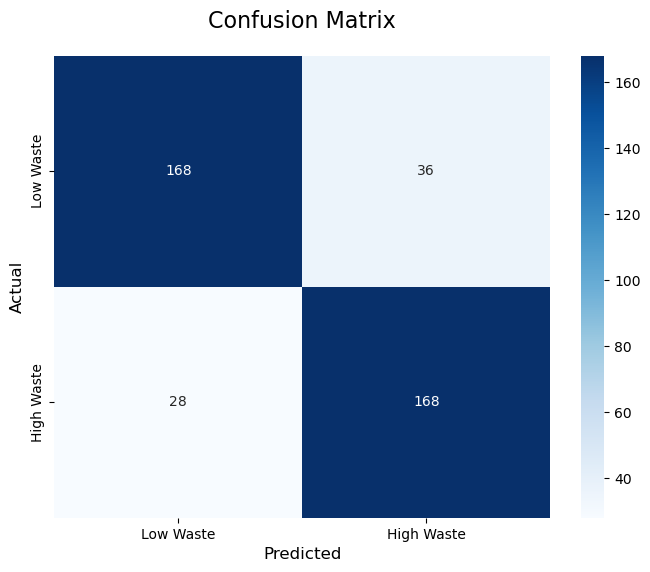

In [710]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Waste', 'High Waste'],
            yticklabels=['Low Waste', 'High Waste'])
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

In [711]:
def predict_waste(material_type, area, thickness):
    try:
        material_encoded = label_encoder.transform([material_type])[0]
    except:
        print(f"Unknown material type: {material_type}")
        return None
    
    input_df = pd.DataFrame([[area, thickness, material_encoded]],
                             columns=['Area (sq/m)', 'Thickness (mm)', 'Material Type Encoded'])
    
    features_scaled = scaler.transform(input_df)
    
    prediction = knn.predict(features_scaled)[0]
    probs = knn.predict_proba(features_scaled)[0]
    
    return {
        'prediction': 'High Waste' if prediction == 1 else 'Low Waste',
        'prediction_code': int(prediction),
        'low_waste_prob': probs[0],
        'high_waste_prob': probs[1],
        'confidence': probs[prediction]
    }

In [712]:
def print_result(case, result):
    bar_length = 20
    low_bar  = round(result['low_waste_prob']  * bar_length)
    high_bar = round(result['high_waste_prob'] * bar_length)

    print("=" * 45)
    print(f"  Material Type : {case['material_type']}")
    print(f"  Area          : {case['area']} sq/m")
    print(f"  Thickness     : {case['thickness']} mm")
    print("-" * 45)
    print(f"  Prediction    : {result['prediction'].upper()}")
    print(f"  Confidence    : {result['confidence']:.1%}")
    print()
    print(f"  Low  Waste  {'█' * low_bar}{'░' * (bar_length - low_bar)}  {result['low_waste_prob']:.1%}")
    print(f"  High Waste  {'█' * high_bar}{'░' * (bar_length - high_bar)}  {result['high_waste_prob']:.1%}")
    print("=" * 45)
    print()


test_cases = [
    {'material_type': 'GI', 'area': 58.0,  'thickness': 1.10},
    {'material_type': 'PI', 'area': 12.0,  'thickness': 20.0},
]

for case in test_cases:
    result = predict_waste(case['material_type'], case['area'], case['thickness'])
    if result:
        print_result(case, result)

  Material Type : GI
  Area          : 58.0 sq/m
  Thickness     : 1.1 mm
---------------------------------------------
  Prediction    : LOW WASTE
  Confidence    : 85.7%

  Low  Waste  █████████████████░░░  85.7%
  High Waste  ███░░░░░░░░░░░░░░░░░  14.3%

  Material Type : PI
  Area          : 12.0 sq/m
  Thickness     : 20.0 mm
---------------------------------------------
  Prediction    : HIGH WASTE
  Confidence    : 85.7%

  Low  Waste  ███░░░░░░░░░░░░░░░░░  14.3%
  High Waste  █████████████████░░░  85.7%

